<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#SVC" data-toc-modified-id="SVC-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SVC</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Корреляция-между-метриками-и-сэкономленными-деньгами" data-toc-modified-id="Корреляция-между-метриками-и-сэкономленными-деньгами-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Корреляция между метриками и сэкономленными деньгами</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

Компания «Морские гады» доставляет корпоративным клиентам блюда из морепродуктов. На прибыль сильно влияет отмена заказов, потому что их не оплачивают, а товар приходится выбрасывать. Морепродукты нельзя замораживать повторно, иначе портится вкус. Менеджмент задумал отбивать себестоимость и ввести предоплату, но для этого необходима модель, которая будет предсказывать отмену заказов.

Менеджмент задумал отбивать себестоимость и ввести предоплату, но осторожно. Опыт показывает, что эта мера отпугивает 20% клиентов. Решено запрашивать предоплату 70% в тех случаях, когда есть явный риск отмены заказа. Вам нужно научиться предсказывать такие случаи. При этом важно сэкономить больше 850 тыс. рублей, чтобы окупить затраты на новое решение.

«Морские гады» предоставили датасет за последние несколько месяцев. Владелец данных предупредил:

Бизнес небольшой, поэтому информации мало.
Клиенты и заказы бывают разные. Нужна модель, которая сможет делать предсказания для любых случаев.

Такие вводные означают, что нужно учесть все данные. Удалять нетипичные объекты из признакового описания нельзя.

А вот и новая информация о клиентах «Морских вкуснях» и их заказах. У нас появилась выборка с обновленными данными о заказах. Изучите данные файла `orders_seafood_new.csv`.

Напомним описание признаков заказчика:

* `client_id` — идентификатор клиента;
* `reject_count` — количество отменённых заказов за всю историю;
* `confirm_count` — количество подтверждённых заказов;
* `last_summ` — сумма, полученная от клиента за всю историю;
* `summ_`— стоимость последнего заказа клиента;
* `count_position` — число позиций в последнем заказе;
* `target` — заказ отменён (1), заказ подтверждён (0).


## Подготовка данных

In [ ]:
# Загрузим необходимые библиотеки
import pandas as pd  #Основной инструмент аналитика — `pandas`.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Загрузим необходимые модели для классификации и метрики качества
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score



import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 123

In [ ]:
# Прочитаем файл с данными в переменную df и изучим их
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/orders_seafood.csv')
    df_new = pd.read_csv('/content/drive/My Drive/orders_seafood_new.csv')
except:
    df = pd.read_csv('orders_seafood.csv')
    df_new = pd.read_csv('orders_seafood_new.csv')

Mounted at /content/drive


In [ ]:
# первые 5 строк нового датасета
df_new.head()

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
0,180224,8,173,136444.7,18747.0,11,0
1,118790,6,10,50043.7,26028.1,16,1
2,143366,7,17,190715.9,32471.4,19,1
3,135176,5,23,140677.7,39759.9,18,1
4,135175,2,19,92773.0,17608.3,10,1


Посмотрим, сильно ли отличаются друг от друга новые и старые данные. Изучим описательную статистику каждого датасета методом `describe()`:

In [ ]:
# Описательная статистика старых данных
df.describe()

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,8911.952000,20.524000,43.281333,117236.968533,13642.938933,8.010667,0.700000
std,6815.642179,6.190896,55.671117,33535.611602,11264.546470,6.231184,0.458563
min,25.000000,5.000000,5.000000,32896.400000,1460.100000,1.000000,0.000000
25%,1030.250000,16.000000,14.000000,98092.800000,5028.400000,3.000000,0.000000
50%,8928.000000,21.000000,17.000000,120045.100000,8134.700000,5.000000,1.000000
75%,16768.000000,25.000000,24.750000,142483.850000,22788.950000,13.000000,1.000000
max,17776.000000,39.000000,204.000000,191564.800000,69465.900000,30.000000,1.000000


In [ ]:
# Описательная статистика новых данных
df_new.describe()

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,150260.001818,5.378182,33.627273,120544.595636,10061.329636,5.980000,0.616364
std,28835.926536,4.188052,40.578077,33906.236783,8875.699406,5.002509,0.486714
min,102602.000000,0.000000,6.000000,30431.200000,1391.700000,1.000000,0.000000
25%,125597.000000,2.000000,14.000000,99622.075000,4837.450000,3.000000,0.000000
50%,149653.500000,4.000000,18.000000,122427.550000,6736.400000,4.000000,1.000000
75%,174543.750000,7.000000,24.000000,145620.300000,11080.925000,6.000000,1.000000
max,201451.000000,21.000000,198.000000,219305.000000,49446.700000,28.000000,1.000000


Сравнивая данные, в первую очередь смотрите на медиану, а не на среднее — это более робастная оценка распределения.
Обратите внимание на медианы признаков `reject_count` и `summ_`.


Количество отказов существенно сократилось — предоплата оправдала себя.

Это указывает на то, что распределение признаков в тренировочной и тестовой выборках заметно различается. Похоже, произошли структурные изменения, о которых модель не знала и поэтому не сможет учитывать в будущем.

У этого может быть много причин: например, в меню появились новые позиции, исчезла часть старых, выросла цена на блюда или появились промоакции или предоплаты заказов. Специалисты по Data Science должны отслеживать такие изменения, чтобы поддерживать модель в актуальном состоянии.

В вашем случае всё оказалось просто: похоже, ещё до внедрения модели заказчик решил ввести предоплату! Правда, опирался он не на модель машинного обучения, а просто ввёл её на все заказы. Вот бы ещё вам эту информацию сообщили вовремя…

Из-за таких структурных изменений больше нельзя просто использовать старую тренировочную выборку для обучения модели — теперь она стала аномальной.

Вот что с этим можно сделать:
* Удалить наблюдения, где значение признака reject_count сильно выше, чем в новых данных. Так исходные данные будут выровнены под новую тестовую выборку.
* Использовать для обучения тестовую выборку.

Второй вариант предпочтительнее. Это связано с тем, что в случае с «Морскими гадами» структурные изменения нельзя экстраполировать на старые данные. Отмены заказов в прошлом никак не связаны с нововведениями, и даже клиенты с тем же количеством отмен могли их делать по другой причине.

Ваша модель всё ещё востребована. Теперь её необходимо адаптировать под новые реалии.

Новый датасет не больше старых данных, но он всё равно не слишком большой. Поэтому стоит объединить все данные, чтобы модель могла лучше обучиться.

Объединяем данные и затем делим их на тренировочную и валидационную выборки.

Для объединения двух датасетов используем метод `concat()`.

In [ ]:
# объединяем данные
all_data = pd.concat([df,df_new],axis=0)

In [ ]:
# оценим числовые характеристики данных
all_data.describe()

,client_id,reject_count,confirm_count,last_summ,summ_,count_position,target
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,68713.050000,14.116154,39.196923,118636.349231,12127.642692,7.151538,0.664615
std,72515.927305,9.249158,50.056947,33719.547344,10468.625314,5.828519,0.472306
min,25.000000,0.000000,5.000000,30431.200000,1391.700000,1.000000,0.000000
25%,8608.500000,5.000000,14.000000,99008.875000,4974.500000,3.000000,0.000000
50%,17252.500000,14.000000,17.000000,120795.300000,7496.350000,5.000000,1.000000
75%,139327.000000,22.000000,24.000000,144464.800000,17331.300000,10.000000,1.000000
max,201451.000000,39.000000,204.000000,219305.000000,69465.900000,30.000000,1.000000


In [ ]:
# Оценим баланс классов
all_data['target'].value_counts(normalize=True)

target
1    0.664615
0    0.335385
Name: proportion, dtype: float64

Видим дисбаланс классов, поэтому для обучения моделей будем использовать взвешивание классов.

Для обучения моделей выделим целевой признак и факторы.

In [ ]:
X =all_data.drop(columns=['target','client_id'])
y =all_data['target']

Разделим выборку на тренировочную и тестовую в соотношении 75:25. Используем метод `train_test_split`.

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X,y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)


Также руководство «Морских гадов» передало, что цели экономить 850 тысяч рублей больше нет, потому что закончился основной сезон, когда к ним обращаются клиенты. Теперь нужно просто сберечь как можно больше средств.

In [ ]:
# Для интерпретации модели логистической регрессии нормализуем данные
# Обучим и преобразуем количественные признаки из тренировочной и тестовой выборок
# для тренировочной выборки выполним действия одной командой

scaler = StandardScaler()
X_train_scalled =scaler.fit_transform(X_train)
X_test_scalled =scaler.transform(X_test)


## Логистическая регрессия

In [ ]:
# Инициируем класс логистической регрессии и обучим модель на стандартизованных данных

logreg =LogisticRegression(class_weight='balanced').fit(X_train_scalled,y_train)
# Построим прогноз на валидационной выборке

y_pred =logreg.predict(X_test_scalled)

# Вычислим метрику accuracy на валидационной выборке
r = accuracy_score(y_test,y_pred)
r

0.5846153846153846

Модель звёзд с небес не хватает, но она и не должна: это лишь стартовая точка для поиска более точных решений.

Логистическая регрессия улавливает только линейные зависимости, поэтому её можно улучшить, добавив в признаковое описание полиномиальные признаки с помощью полиномизации.

In [ ]:
# Формируем полиномиальные признаки до 2 порядка
poly = PolynomialFeatures(2)

X_train =poly.fit_transform(X_train)
X_test =poly.transform(X_test)

In [ ]:
# сохранение таблицы X_test с полиномиальными признаками до стандартизации
X_test_df = pd.DataFrame(X_test,columns = poly.get_feature_names_out())


In [ ]:
# стандартизация
X_train_scalled =pd.DataFrame(scaler.fit_transform(X_train),columns=poly.get_feature_names_out())
X_test_scalled =pd.DataFrame(scaler.transform(X_test),columns=poly.get_feature_names_out())


In [ ]:
# инициализируем и обучаем модель
# считаем accuracy
model =LogisticRegression(class_weight='balanced').fit(X_train_scalled,y_train)


acc1 = accuracy_score(y_test,model.predict(X_test_scalled))
acc1

0.6153846153846154

Прирост на три процента — медленно, но верно!

Построим график важности признаков, т.е. коэффициентов регрессии (будем оценивать их значения по модулю):

<Axes: ylabel='Feature'>

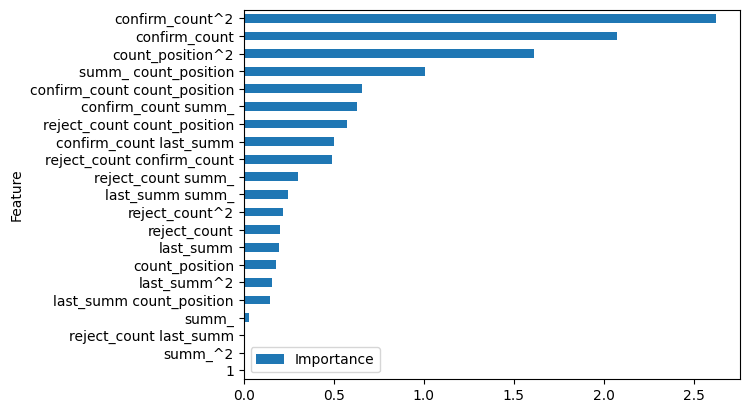

In [ ]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': poly.get_feature_names_out(),
                                   'Importance': np.abs(coefficients)}).sort_values('Importance', ascending=True)

# График важности признаков
feature_importance.plot(x='Feature',y='Importance', kind='barh')



Видно, что не все входные признаки хорошо объясняют целевой. А значит, некоторыми можно пренебречь.

Чтобы отобрать признаки, используем `SelectKBest` несколько раз с помощью цикла. Заодно проверим, сколько средств сэкономили бы «Морские гады», если бы остановились на разных `k`.

Напоминаем:
* каждая предсказанная отмена заказа сохранит компании 0.7*0.8 от стоимости заказа, где 0.7 — это размер предоплаты, 0.8 — поправка на клиентов, которые откажутся от заказа из-за предоплаты;
* компания также потеряет 0.2 от суммы заказа в случае ошибочно предсказанной отмены.


In [ ]:
accs_logreg = []
money_logreg = []

for i in range(len(X_test_df.columns)):
        # объявляем селектор
    # он будет подбирать разное количество признаков за счёт цикла
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    # сохраняем названия признаков в переменную features_names
    features_names = selector.get_feature_names_out()

    # стандартизируем признаки
    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    # инициализируем и обучаем модель
    model = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_STATE)
    model.fit(X_train_new, y_train)

    acc_new = accuracy_score(y_test, model.predict(X_test_new))


    # создаём таблицы предсказаний для подсчёта сэкономленных средств
    predicts = X_test_df[['summ_']].copy()
    predicts['logreg'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['logreg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['logreg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    accs_logreg.append(acc_new)
    money_logreg.append(TP-FP)

    print('Число признаков: ', i+1, 'accuracy_last = ', round(acc1, 5), 'accuracy = ', round(acc_new, 5), 'money = ', round(TP-FP,3))


Число признаков:  1 accuracy_last =  0.61538 accuracy =  0.56308 money =  1194636.872
Число признаков:  2 accuracy_last =  0.61538 accuracy =  0.56308 money =  1183943.608
Число признаков:  3 accuracy_last =  0.61538 accuracy =  0.56308 money =  1183943.608
Число признаков:  4 accuracy_last =  0.61538 accuracy =  0.56308 money =  1183943.608
Число признаков:  5 accuracy_last =  0.61538 accuracy =  0.56308 money =  1183943.608
Число признаков:  6 accuracy_last =  0.61538 accuracy =  0.56 money =  1174551.512
Число признаков:  7 accuracy_last =  0.61538 accuracy =  0.56 money =  1174551.512
Число признаков:  8 accuracy_last =  0.61538 accuracy =  0.56308 money =  1180292.312
Число признаков:  9 accuracy_last =  0.61538 accuracy =  0.56 money =  1178402.912
Число признаков:  10 accuracy_last =  0.61538 accuracy =  0.59385 money =  1262841.792
Число признаков:  11 accuracy_last =  0.61538 accuracy =  0.59385 money =  1276501.388
Число признаков:  12 accuracy_last =  0.61538 accuracy =  0.6

Обратите внимание: при 14 признаках модель прирастает в качестве. Это решение также экономит неплохие деньги.


Какие признаки отобрала логистическая регрессия?

In [ ]:
selector = SelectKBest(f_classif,k=14)
selector.fit_transform(X_train_scalled,y_train)

features_names =selector.get_feature_names_out()

features_names

array(['reject_count', 'confirm_count', 'summ_', 'count_position',
       'reject_count^2', 'reject_count last_summ', 'reject_count summ_',
       'reject_count count_position', 'confirm_count^2',
       'last_summ summ_', 'last_summ count_position', 'summ_^2',
       'summ_ count_position', 'count_position^2'], dtype=object)

`SelectKBest` оставил исходные признаки: количество отменённых заказов за всю историю, количество подтверждённых заказов, стоимость последнего заказа клиента и число позиций в последнем заказе. Вместе с ними в модели остались комбинации разных признаков.

Для сравнения надо попробовать другие методы отбора признаков — например, `L1`-регуляризацию.

Инициализируйте и обучите логистическую регрессию с `L1`-регуляризацией на полиномиальных признаках.

Проверьте её работу с разными значениями гиперпараметра `C` при помощи цикла. Выведите на экран все значения `С`, `accuracy` и сэкономленных средств.

In [ ]:
# запускаем цикл, который обучит несколько моделей с разной силой регуляризации
# итоговая выдача — таблица с информацией о C, точности и сэкономленных деньгах
C_ = [0.1,0.4,0.5,0.6,0.7,0.8,1,2,5,10]

for c in C_:
    model = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_STATE, penalty = 'l1' , solver = 'saga',C=c)
    model.fit(X_train_scalled, y_train)

    acc1 = accuracy_score(y_test, model.predict(X_test_scalled))

    predicts = X_test_df[['summ_']].copy()
    predicts['logreg'] = model.predict(X_test_scalled)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['logreg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['logreg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    print('C = ', c, 'accuracy = ', round(acc1, 10), 'money = ', round(TP-FP, 6))

C =  0.1 accuracy =  0.5692307692 money =  1175147.088
C =  0.4 accuracy =  0.6215384615 money =  1252223.508
C =  0.5 accuracy =  0.6215384615 money =  1252223.508
C =  0.6 accuracy =  0.6184615385 money =  1246108.14
C =  0.7 accuracy =  0.6184615385 money =  1246108.14
C =  0.8 accuracy =  0.6215384615 money =  1248020.708
C =  1 accuracy =  0.6215384615 money =  1231844.32
C =  2 accuracy =  0.6215384615 money =  1229132.52
C =  5 accuracy =  0.6184615385 money =  1225260.452
C =  10 accuracy =  0.6153846154 money =  1224040.192


Похоже, модель лучше всего экономит средства при значении `C=0.4`

Вот сколько признаков содержит лучшая модель:

In [ ]:
model =LogisticRegression(class_weight = 'balanced', random_state=RANDOM_STATE, penalty = 'l1' , solver = 'saga',C=0.4)
model.fit(X_train_scalled, y_train)
acc1 = accuracy_score(y_test, model.predict(X_test_scalled))
model.coef_

array([[ 0.        ,  0.010512  ,  1.61437042,  0.        ,  0.        ,
         0.01952166,  0.        ,  0.43692167,  0.        ,  0.        ,
         0.17283511, -2.09937804,  0.39486648, -0.73806725, -0.37450287,
         0.        ,  0.        ,  0.        ,  0.        ,  0.78809601,
         1.39310361]])

<Axes: ylabel='Feature'>

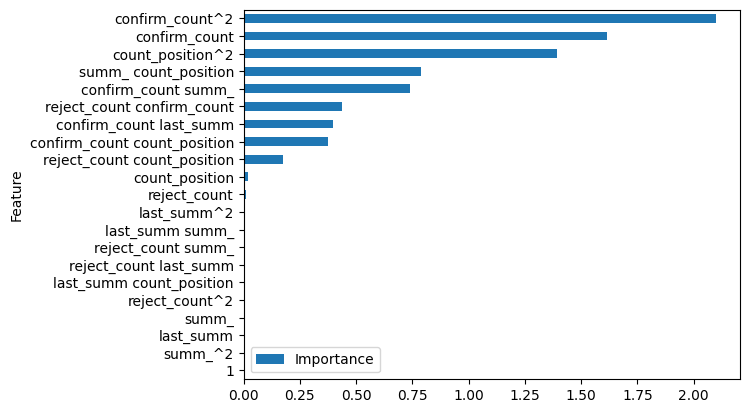

In [ ]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': poly.get_feature_names_out(),
                                   'Importance':np.abs(coefficients )}).sort_values('Importance', ascending=True)

# График важности признаков
feature_importance.plot(x='Feature',y='Importance',kind='barh')

Выходит, модель обнулила коэффициенты десяти признаков, однако она всё равно отобрала признаки менее эффективно, чем `SelectKBest`.

## SVC

Взяв от логистической регрессии максимум, сравним её с другими моделями. Для начала — c `SVM`, которая часто показывала себя хорошо на данных «Морских гадах».

Инициализируем модель `SVC` и посмотрим на качество её предсказаний без настройки гиперпараметров и отбора признаков на полиномиальном наборе признаков

In [ ]:
model =SVC(class_weight='balanced').fit(X_train_scalled,y_train)

acc1 =accuracy_score(y_test,model.predict(X_test_scalled))
acc1

0.6092307692307692

Результат немного хуже, чем у базовой модели. Поможет ли отбор признаков?



Подберите количество лучших признаков для модели `SVC()`. Выведите на экран количество признаков, значение переменной `acc1`, `accuracy` при разном количестве признаков и количество сэкономленных средств компании.

In [ ]:
# объявляем селектор
# он будет подбирать разное количество признаков за счёт цикла
# обучите модель с разным числом признаков и сравните их точность с базовой моделью
for i in range(len(X_test_df.columns)):
    selector = SelectKBest(f_classif, k= i + 1)
    selector.fit(X_train_scalled, y_train)

    features_names = X_train_scalled.columns[selector.get_support(indices=True)]

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = SVC(class_weight = 'balanced', kernel = 'rbf')
    model.fit(X_train_new, y_train)

    acc_new = accuracy_score(y_test, model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['svm'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['svm']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['svm']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    print('Число признаков: ', i+1, 'accuracy_last = ', round(acc1, 5), 'accuracy = ', round(acc_new, 5), 'money = ', round(TP-FP,3))


Число признаков:  1 accuracy_last =  0.60923 accuracy =  0.53846 money =  1102594.108
Число признаков:  2 accuracy_last =  0.60923 accuracy =  0.53846 money =  1102594.108
Число признаков:  3 accuracy_last =  0.60923 accuracy =  0.53846 money =  1102594.108
Число признаков:  4 accuracy_last =  0.60923 accuracy =  0.53846 money =  1102594.108
Число признаков:  5 accuracy_last =  0.60923 accuracy =  0.53846 money =  1102594.108
Число признаков:  6 accuracy_last =  0.60923 accuracy =  0.54154 money =  1111986.204
Число признаков:  7 accuracy_last =  0.60923 accuracy =  0.53846 money =  1102727.78
Число признаков:  8 accuracy_last =  0.60923 accuracy =  0.54154 money =  1111698.924
Число признаков:  9 accuracy_last =  0.60923 accuracy =  0.53846 money =  1102727.78
Число признаков:  10 accuracy_last =  0.60923 accuracy =  0.59077 money =  1177743.116
Число признаков:  11 accuracy_last =  0.60923 accuracy =  0.57846 money =  1158485.84
Число признаков:  12 accuracy_last =  0.60923 accuracy 

Превзойти не удалось, увы. Качество модели остается низкое, несмотря на достаточно высокую экономию средств. Видимо, после внедрения предоплаты данные стали слишком простыми, и `SVM` больше не нужна.

Осталось проверить дерево решений.


Какие признаки отобрал метод опорных векторов?

In [ ]:
selector =SelectKBest(f_classif,k=14)
selector.fit_transform(X_train_scalled, y_train)
features_names =selector.get_feature_names_out()
features_names

array(['reject_count', 'confirm_count', 'summ_', 'count_position',
       'reject_count^2', 'reject_count last_summ', 'reject_count summ_',
       'reject_count count_position', 'confirm_count^2',
       'last_summ summ_', 'last_summ count_position', 'summ_^2',
       'summ_ count_position', 'count_position^2'], dtype=object)

`SelectKBest` оставил исходные признаки: количество отменённых заказов за всю историю, количество подтверждённых заказов, стоимость последнего заказа клиента и число позиций в последнем заказе. Вместе с ними в модели остались комбинации разных признаков.

## Дерево решений

Обучим стандартную модель с полиномиальными признаками:

In [ ]:
# обучим модель, выведем её accuracy
model =DecisionTreeClassifier(class_weight='balanced',random_state=RANDOM_STATE).fit(X_train_scalled,y_train)

acc1 =accuracy_score(y_test,model.predict(X_test_scalled))
acc1

0.6523076923076923

Очень хороший результат! Посмотрим на важность признаков:

<Axes: ylabel='Feature'>

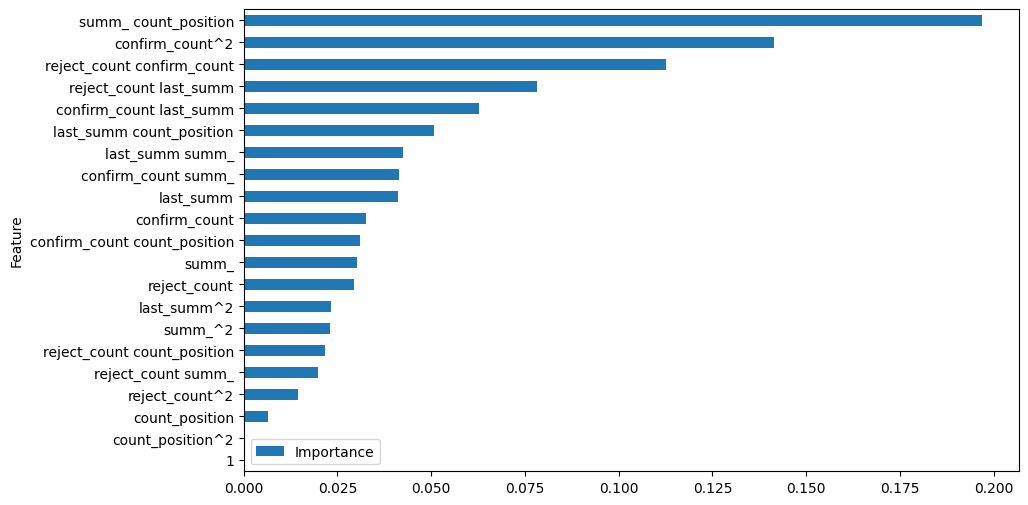

In [ ]:
feature_importance = pd.DataFrame({'Feature': poly.get_feature_names_out(),
                                   'Importance':model.feature_importances_ }).sort_values('Importance', ascending=True)
# График важности признаков
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


От лишних признаков стоит избавиться с помощью `SelectKBest`.

Для линейной регрессии вы использовали статистический тест `f_classif`, поскольку оценивали линейное влияние входных признаков на целевой.

Дерево решений не ищет линейные зависимости, поэтому выбираем другой метод — `mutual_info_classif`:

In [ ]:
accs_tree = []
money_tree = []

# объявляем селектор
# он будет подбирать разное количество признаков за счёт цикла
# обучим модель с разным числом признаков и сравним их с точностью лучшей модели
for i in range(len(X_test_df.columns)):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = DecisionTreeClassifier(class_weight = 'balanced', random_state=RANDOM_STATE)
    model.fit(X_train_new, y_train)

    acc_new = accuracy_score(y_test, model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['tree'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['tree']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['tree']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    accs_tree.append(acc_new)
    money_tree.append(TP-FP)

    print('Число признаков: ', i+1, 'accuracy_last = ', round(acc1, 5), 'accuracy = ', round(acc_new, 5), 'money = ', round(TP-FP,3))



Число признаков:  1 accuracy_last =  0.65231 accuracy =  0.59077 money =  1058410.84
Число признаков:  2 accuracy_last =  0.65231 accuracy =  0.60923 money =  1330183.38
Число признаков:  3 accuracy_last =  0.65231 accuracy =  0.65231 money =  1429783.896
Число признаков:  4 accuracy_last =  0.65231 accuracy =  0.64615 money =  1409864.328
Число признаков:  5 accuracy_last =  0.65231 accuracy =  0.59692 money =  1288062.616
Число признаков:  6 accuracy_last =  0.65231 accuracy =  0.68308 money =  1404862.844
Число признаков:  7 accuracy_last =  0.65231 accuracy =  0.65231 money =  1427843.528
Число признаков:  8 accuracy_last =  0.65231 accuracy =  0.66769 money =  1441018.224
Число признаков:  9 accuracy_last =  0.65231 accuracy =  0.66154 money =  1411147.288
Число признаков:  10 accuracy_last =  0.65231 accuracy =  0.66769 money =  1422618.524
Число признаков:  11 accuracy_last =  0.65231 accuracy =  0.69538 money =  1450872.86
Число признаков:  12 accuracy_last =  0.65231 accuracy 

У дерева решений с 17 и 18 признаками качество выше лучшей версии логистической регрессии, при этом оно экономит больше денег.

Какие признаки отобрало дерево решений?

In [ ]:
selector =SelectKBest(mutual_info_classif,k=11).fit(X_train_scalled, y_train)

features_names =selector.get_feature_names_out()
features_names

array(['confirm_count', 'summ_', 'count_position', 'reject_count summ_',
       'confirm_count^2', 'confirm_count summ_',
       'confirm_count count_position', 'last_summ summ_', 'summ_^2',
       'summ_ count_position', 'count_position^2'], dtype=object)

## Корреляция между метриками и сэкономленными деньгами

Выше мы заметили, что прирост значений метрики не всегда сопровождается большей экономией денег. Разберёмся, почему так.

Для начала нужно посчитать корреляцию Пирсона между `accuracy` и оценкой сберегаемых средств, а затем посмотреть, изменится ли взаимосвязь, если оценивать модель другой метрикой. Также стоит применить эти расчёты к обеим моделям с лучшим качеством: к логистической регрессии и к дереву решений.

Посмотрим на распределение значений логистической регрессии на диаграмме рассеяния:

<Axes: xlabel='money', ylabel='accuracy'>

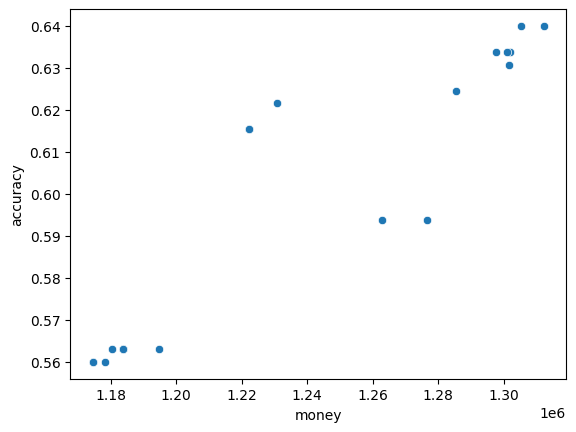

In [ ]:
# строим диаграмму рассеяния между метрикой и сэкономленными деньгами

quality = pd.DataFrame()
quality['money'] = money_logreg
quality['accuracy'] = accs_logreg

# Диаграмма рассеяния accuracy от money
sns.scatterplot(x=quality['money'],y=quality['accuracy'])

Видим некоторую зависимость. Вычислим коэффициент корреляции:

In [ ]:
quality.corr()

,money,accuracy
money,1.000000,0.919719
accuracy,0.919719,1.000000


Теперь посмотрим на связь между сэкономленными деньгами и `ROC-AUC`:

In [ ]:
rocs = []
money = []
for i in range(len(X_test_df.columns)):
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = LogisticRegression(class_weight = 'balanced')
    model.fit(X_train_new, y_train)

    roc1 = roc_auc_score(y_test.tolist(), model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['logreg'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['logreg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7**0.8
    FP = predicts[(predicts['logreg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    rocs.append(roc1)
    money.append(TP-FP)

Коэффициент корреляции =  0.7145936486235094


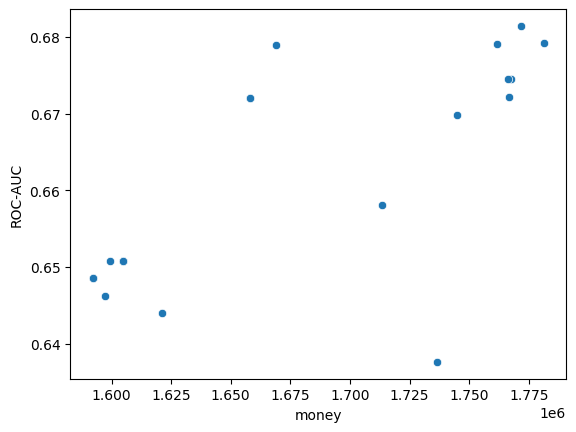

In [ ]:
quality = pd.DataFrame()
quality['money'] = money
quality['ROC-AUC'] = rocs

# Диаграмма рассеяния ROC-AUC от money
a = sns.scatterplot(data = quality, x = 'money', y = 'ROC-AUC')
print('Коэффициент корреляции = ',quality['money'].corr(quality['ROC-AUC']) )

Лучше не стало… А что насчёт `F1`-меры?

In [ ]:
f1= []
money = []

for i in range(len(X_test_df.columns)):
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = LogisticRegression(class_weight = 'balanced')
    model.fit(X_train_new, y_train)

    f1_new = f1_score(y_test, model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['logreg'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['logreg']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['logreg']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    f1.append(f1_new)
    money.append(TP-FP)

    print('Число признаков: ', i+1, 'f1 = ', round(f1_new, 5), 'money = ', round(TP-FP,3))

Число признаков:  1 f1 =  0.54777 money =  1194636.872
Число признаков:  2 f1 =  0.53896 money =  1183943.608
Число признаков:  3 f1 =  0.53896 money =  1183943.608
Число признаков:  4 f1 =  0.53896 money =  1183943.608
Число признаков:  5 f1 =  0.53896 money =  1183943.608
Число признаков:  6 f1 =  0.5342 money =  1174551.512
Число признаков:  7 f1 =  0.5342 money =  1174551.512
Число признаков:  8 f1 =  0.53896 money =  1180292.312
Число признаков:  9 f1 =  0.53722 money =  1178402.912
Число признаков:  10 f1 =  0.60241 money =  1262841.792
Число признаков:  11 f1 =  0.62286 money =  1276501.388
Число признаков:  12 f1 =  0.66289 money =  1297609.56
Число признаков:  13 f1 =  0.66667 money =  1301973.528
Число признаков:  14 f1 =  0.67409 money =  1312115.632
Число признаков:  15 f1 =  0.66667 money =  1301006.856
Число признаков:  16 f1 =  0.65341 money =  1285424.74
Число признаков:  17 f1 =  0.67227 money =  1305342.204
Число признаков:  18 f1 =  0.66292 money =  1301429.66
Число 

Кажется, что прирост стал гораздо более синхронным. Посмотрим, заметна ли разница на графике и по коэффициенту корреляции:

Коэффициент корреляции =  0.941256835145834


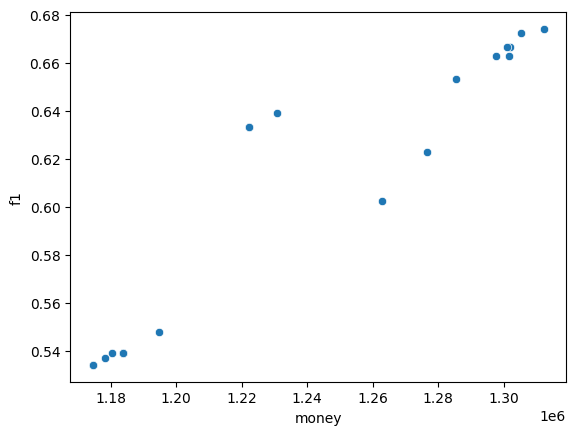

In [ ]:
quality = pd.DataFrame()
quality['money'] = money
quality['f1'] = f1

# Диаграмма рассеяния f1 от money
a = sns.scatterplot(data = quality, x = 'money', y = 'f1')
print('Коэффициент корреляции = ',quality['money'].corr(quality['f1']) )

Теперь взглянем на то, есть ли такая же взаимосвязь у показателей дерева решений.

Сначала оценим корреляцию между сэкономленными средствами и метрикой `accuracy`.

Коэффициент корреляции = 0.8053463115191611


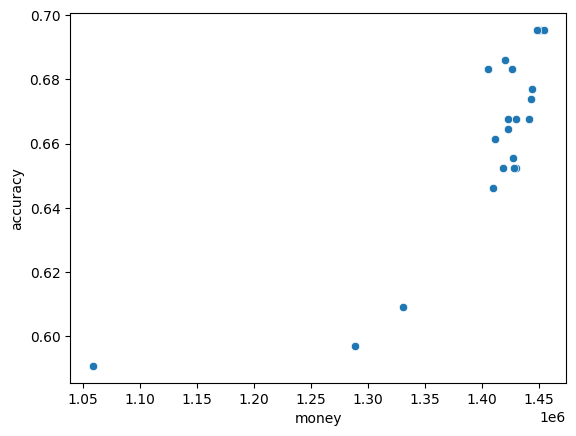

In [ ]:
quality = pd.DataFrame()
quality['money'] = money_tree
quality['accuracy'] = accs_tree

# Диаграмма рассеяния accuracy от money
a = sns.scatterplot(data = quality, x = 'money', y = 'accuracy')
print('Коэффициент корреляции =', quality['money'].corr(quality['accuracy']))

Теперь посмотрим на корреляцию между метрикой `f1` и сэкономленными деньгами.

In [ ]:
f1= []
money = []

for i in range(len(X_test_df.columns)):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model = DecisionTreeClassifier(class_weight = 'balanced', random_state=RANDOM_STATE)
    model.fit(X_train_new, y_train)

    f1_new = f1_score(y_test, model.predict(X_test_new))

    predicts = X_test_df[['summ_']].copy()
    predicts['tree'] = model.predict(X_test_new)
    predicts['y_test'] = y_test.tolist()

    TP = predicts[(predicts['tree']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['tree']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2

    f1.append(f1_new)
    money.append(TP-FP)

    print('Число признаков: ', i+1, 'f1 = ', round(f1_new, 10), 'money = ', round(TP-FP,3))


Число признаков:  1 f1 =  0.5424836601 money =  1141396.584
Число признаков:  2 f1 =  0.6952380952 money =  1288745.28
Число признаков:  3 f1 =  0.6983372922 money =  1312624.296
Число признаков:  4 f1 =  0.6983372922 money =  1312730.08
Число признаков:  5 f1 =  0.7417840376 money =  1378047.608
Число признаков:  6 f1 =  0.7242990654 money =  1396622.3
Число признаков:  7 f1 =  0.7285382831 money =  1407089.168
Число признаков:  8 f1 =  0.7534246575 money =  1441018.224
Число признаков:  9 f1 =  0.7441860465 money =  1411147.288
Число признаков:  10 f1 =  0.7320574163 money =  1375156.9
Число признаков:  11 f1 =  0.7599067599 money =  1428753.736
Число признаков:  12 f1 =  0.7612293144 money =  1436071.132
Число признаков:  13 f1 =  0.7494033413 money =  1407833.824
Число признаков:  14 f1 =  0.7289719626 money =  1383686.1
Число признаков:  15 f1 =  0.7614678899 money =  1445172.176
Число признаков:  16 f1 =  0.7546296296 money =  1415498.388
Число признаков:  17 f1 =  0.7800453515 m

Диаграмма рассеяния и коэффициент корреляции:

In [ ]:
quality = pd.DataFrame()
quality['money'] = money
quality['f1'] = f1
# Диаграмма рассеяния f1 от money
a = sns.scatterplot(data = quality, x = 'money', y = 'f1')
print('Коэффициент корреляции =',quality['money'].corr(quality['accuracy']))

Итак, зафиксируем результаты анализа:
* Оптимальный баланс экономии средств, качества модели и количества признаков показала модель дерева решений с 18 признаками.
* Подходящая метрика для задачи — F1-мера.

## Выводы

* Отбор модели и признаков для задачи — это постепенный процесс. Сначала вы обучаете бейзлайн-модель, затем смотрите на её метрики, а потом начинаете искать более надёжные решения, превосходящие базовое по качеству.
* Чтобы качественно отобрать признаки, нужно провести тщательный анализ данных и подобрать подходящие для вашей ситуации инструменты. К примеру, перед использованием регрессий достаточно выявить линейные закономерности, а для других моделей подойдут иные статистические тесты.
* Не всегда базовая метрика будет коррелировать с показателем, который вы должны улучшить, внедрив модель МО. Поэтому всегда уделяйте время подбору метрики, которая будет корректно отражать способность модели решать вашу задачу.